### Convolutional neural network - Simpsons Family

Em algum momento da sua vida, eu tenho certeza que você já deve ter assistido os Simpsons! Simpsons se tornou um clássico e uma das famílias mais conhecida no mundo todo. Será que conseguimos criar uma rede neural convolucional para diferenciar cada familiar?

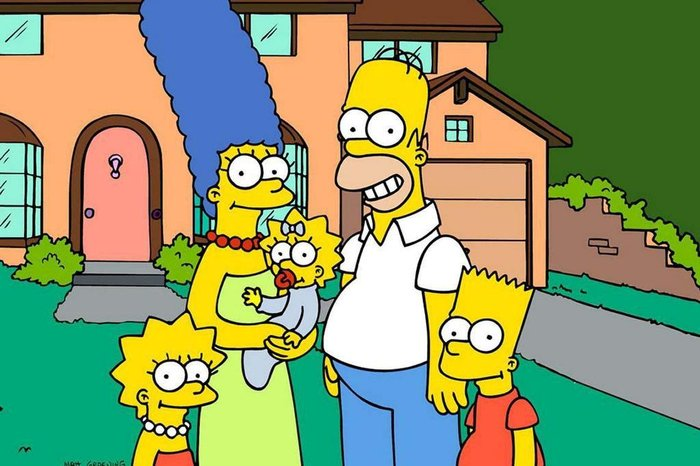

## Importando bibliotecas

In [ ]:
#!pip install opencv-python

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import cv2

# Para Deep Learning
import keras
import tensorflow.keras
from keras.models import Sequential 

from keras.layers import MaxPooling2D
from keras.layers import Flatten

from keras.layers import Dense, Dropout, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.optimizers import Adam

import tensorflow as tf

# Para validação do modelo
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Carregando a base de dados

In [ ]:
# Carregando as imagens
pasta_imagens = Path("C:/Users/cl1476/Desktop/SHIFT - Deep Learning/CNN/simpsons_dataset/simpsons_dataset")

In [ ]:
# Listando todas as imagens do diretório
filepaths = list(pasta_imagens.glob(r'**/*.jpg'))
filepaths

## Tratando os dados

In [ ]:
# Inicializando rótulos e listas de imagens para armazenar os dados
labels = [] #armazenando as variáveis target
images = [] #armazenando imagens

In [ ]:
labels

In [ ]:
# Definindo o tamanho da dimensão da imagem
image_size = 64

In [ ]:
# Um loop for para definir as variáveis x e y para os modelos
for filepath in filepaths:
    # Divide o nome do caminho para extrair o cabeçalho do caminho
    head = os.path.split(filepath)
    # Divide o cabeçalho do caminho anterior para extrair o nome do personagem
    character = os.path.split(head[0])
    # Armazena o nome do personagem na lista de labels
    labels.append(character[1])
    # Obtem a imagem do caminho
    img = cv2.imread(str(filepath))
    # Redimensiona a imagem e normalize o intervalo de pixels para ficar entre 0 e 1
    img = cv2.resize(img, (image_size, image_size)).astype('float32') / 255.0 #padronização
    # Adiciona a imagem na lista de imagens
    images.append(img)
    
# Converte a imagem em lista de array
images = np.array(images)
# Converte as labels para lista de array
labels = np.array(labels)

In [ ]:
# Salvando a lista de caminhos de arquivo como um dataframe pandas
pd_filepaths = pd.Series(filepaths, name='Filepath').astype(str)

In [ ]:
# Adicionando a label
pd_labels = pd.Series(labels, name='Label')

In [ ]:
# Concatenando the filepaths and labels
df = pd.concat([pd_filepaths, pd_labels], axis=1)

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
# Embaralhando o dataframe
df = df.sample(frac=1).reset_index(drop = True)

In [ ]:
df.head()

In [ ]:
# Cria uma cópia do dataframe com apenas uma imagem de cada personagem
df_singles = df.copy().drop_duplicates(subset=('Label')).reset_index()

In [ ]:
len(df_singles)

In [ ]:
# Define o número de classes
num_classes = df_singles.shape[0]

In [ ]:
num_classes

In [ ]:
# Configura o número de linhas e colunas para visualizar os dados no plot
ROW = 1
COLUMN = 5

# Dimensões das imagens
plt.figure(figsize=(12, 9)) 
#Loop para cada personagem
for i in range(num_classes):
    # Defina uma variável de imagem local para i imagem no dataframe de singles
    image = df_singles.Filepath[i]
    # Define a posição da imagem a ser plotada
    plt.subplot(ROW, COLUMN, i+1)
    # Mostra a imagem
    plt.imshow(plt.imread(image))
    # Adiciona o rótulo do personagem que corresponde à imagem
    plt.title('{}'.format(df_singles.Label[i]))
    # Desliga o eixo de plotagem
    plt.axis('off')
    # Faça com que o preenchimento ao redor das imagens seja mínimo
    plt.tight_layout()       
plt.show()


## Criando a rede neural convolucional para prever os personagens

## Separando em treino e teste

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images,
                                           labels, test_size=0.2, stratify=labels, random_state=44)


In [ ]:
# Achatar os dados de teste e treinamento
x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2]* x_train.shape[3])
x_test_flat = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

In [ ]:
len(x_train)

In [ ]:
len(x_test)

## Label Enconding para os rótulos (classes)

In [ ]:
y_train

In [ ]:
# Converter Strings em Numéricos
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Converte um vetor de classe (inteiros) em uma matriz de classe categórica.
y_train_tf = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test_tf = tensorflow.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
y_train_tf

## Definições de hiperparametros do modelo

In [ ]:
from distutils.file_util import copy_file

# Defina um objeto ModelCheckpoint para usar os melhores pesos para este modelo
checkpointer = ModelCheckpoint(filepath="weights.best.hdf5", verbose=0, save_best_only=True) # save best model

# Define a forma de entrada das imagens passadas pelo modelo
input_shape = (image_size, image_size, 3)

# Defina a taxa de aprendizado e a queda de peso para o otimizador usar
learning_rate = 0.001
weight_decay = 1e-4

In [ ]:
 #método Ridge, com o parâmetro lambda, penaliza os coeficientes que assumem valores muito grandes, levando-os a tender a zero

## Arquitetura do modelo de CNN

In [ ]:
#Modelo 3

tf.random.set_seed(44)

model = Sequential()

model.add(Conv2D(128, 
                 kernel_size=(3, 3), 
                 strides=(2, 2), 
                 padding='valid',
                 activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(0.001), 
                 input_shape=input_shape)), #1 camada

model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

In [ ]:
# Monitor para interromper o modelo antecipadamente quando a melhoria da perda de validação for mínima
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=1, mode='auto') #Aqui utilizando early stopping

# Compilando o modelo
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=['accuracy'])

# Salve os dados do modelo em um arquivo h5
model.save('./simpsons.h5')
# Resumo do modelo
model.summary()

In [ ]:
# Treinando o modelo
history = model.fit(x_train,y_train_tf, validation_split=0.20, callbacks=[monitor,checkpointer],
                    verbose=1,epochs=25, batch_size=100, shuffle=True)     

In [ ]:
# Validação o erro por épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Validação da acurácia por épocas
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Armazena as predicações do modelo dos dados de teste em uma variável
cnn_pred_simpsons = model.predict(x_test)

In [ ]:
# Define o índice do valor máximo do modelo de previsão para uma variável
# O valor máximo indica o caractere de previsão do modelo que a imagem representa
cnn_pred_simpsons = np.argmax(cnn_pred_simpsons,axis=1)

In [ ]:
# Define uma variável para armazenar o rótulo que representa o caractere verdadeiro
y_true = np.argmax(y_test_tf,axis=1)

In [ ]:
# Cria um array de nomes de caracteres igual ao array de labels
character_names = labels

In [ ]:
# Reduza os nomes dos personagens para apenas valores dict únicos
character_names = list(dict.fromkeys(character_names))

In [ ]:
# Ordena os caracteres em ordem alfabética, qual é a ordem em que os dados são alimentados
character_names = sorted(character_names)

In [ ]:
# Criando a matriz de confusão
cnn_cm_simpsons = metrics.confusion_matrix(y_true, cnn_pred_simpsons)
# Definindo a acurácia
cnn_accuracy_simpsons = metrics.accuracy_score(y_true, cnn_pred_simpsons)

# Print do classification report
print(metrics.classification_report(y_true, cnn_pred_simpsons, target_names=character_names))
# Print da acurácia
print("Accuracy score: {}".format(cnn_accuracy_simpsons))

In [ ]:
# Plotando e salvando a confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cnn_cm_simpsons, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(character_names))
plt.xticks(tick_marks, character_names, rotation=10)
plt.yticks(tick_marks, character_names)
plt.savefig('simpsons_CNN.tiff')
plt.show()

In [ ]:
#Função para adivinhar o personagem
def guess_character(filepath):
    # Converte o caminho do arquivo para uma imagem
    image = cv2.imread(filepath)
    # Redimensione a imagem e normalize o intervalo de pixels para ficar entre 0 e 1
    img = cv2.resize(image, (image_size, image_size)).astype('float32') / 255.0
    # Expandir a forma do array de imagens
    img = np.expand_dims(img, axis=0)
    # Usando o modelo para prever o personagem que representa a imagem
    pred = model.predict(img)
    # Definindo uma variável para armazenar o índice que representa o caractere que representa a imagem
    classes=np.argmax(pred,axis=1)
    # Print no nome do personagem previsto
    print(character_names[classes[0]])
    # Plote a imagem do personagem
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Desliga o eixo de plotagem
    plt.axis('off')

In [ ]:
guess_character('C:/Users/cl1476/Desktop/SHIFT - Deep Learning/CNN/kaggle_simpson_testset/kaggle_simpson_testset/homer_simpson_39.jpg')

In [ ]:
guess_character('C:/Users/cl1476/Desktop/SHIFT - Deep Learning/CNN/kaggle_simpson_testset/kaggle_simpson_testset/marge_simpson_2.jpg')

In [ ]:
guess_character('C:/Users/cl1476/Desktop/SHIFT - Deep Learning/CNN/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_3.jpg')

In [ ]:
guess_character('C:/Users/cl1476/Desktop/SHIFT - Deep Learning/CNN/kaggle_simpson_testset/kaggle_simpson_testset//lisa_simpson_26.jpg')